Osnabrück University - Computer Vision (Winter Term 2021/22) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 03: Morphological Operations¶

## Introduction

This week's sheet should be solved and handed in before the end of **Tuesday, November 23, 2021**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (complex numbers) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is a *complex number*, what is the *complex plane*, how are complex numbers usually denoted?

YOUR ANSWER HERE

**b)** What is the *real* and the *imaginary* part of a complex number? What is the *absolute value* of a complex number? What is the *complex conjugate*?

YOUR ANSWER HERE

**c)** What are polar coordinates? What are their advantages? Can you convert between cartesian and polar coordinates? Can you write down $i=\sqrt{-1}$ in polar coordinates? What about $\sqrt{i}$?

YOUR ANSWER HERE

**d)** Python, and also numpy, support calculations with complex numbers. Consult the documentation to find out details. Notice that $i$ is substituted by $j$ in Python.

In [1]:
# YOUR CODE HERE

## Assignment 1: Properties of morphological operators [5 Points]

This exercise will elaborate on the basic morphological operators of *erosion* and *dilation* (cf. CV-05 slides 4-14).

## Find our solutions for Task 1 in the folder /Task 1

### a) Duality

Proof that *erosion* and *dilation* are *dual* operators, i.e.

$$ g^{\ast}\oplus S = (g\ominus S)^{\ast}\qquad\text{and}\qquad
g^{\ast}\ominus S = (g\oplus S)^{\ast}$$

here $g^{\ast}$ denotes the inverted binary image, i.e. $g^{\ast}(x,y) = 1 - g(x,y) = \neg g(x,y)$, i.e. 1-pixel become 0 and 0-pixel become 1.

solution in folder /Task 1

### b) Superposition

As *erosion* and *dilation* have been introduced for binary images, the notion of *linearity* is not really appropriate here. However, some weaker version, called *superposition* can be defined: instead of forming linear combination, one takes the logical disjunction:

$$(g_1\lor g_2)(x,y) := g_1(x,y)\lor g_2(x,y)$$

Check for both operations if *erosion* and *dilation* are "compatible" with superposition, i.e. if first *eroding* (or *dilating*) two images and superposing the result is the same as first superposing the images and then *eroding* (or *dilating*) the result.

solution in folder /Task 1

### c) Chaining

Show that *dilation* and *erosion* have the following properties: given two structering elements $S_1$ and $S_2$, it holds

\begin{align}
  (g\oplus S_1)\oplus S_2 & & = & g\oplus (S_1\oplus S_2) && = (g\oplus S_2)\oplus S_1 \\
  (g\ominus S_1)\ominus S_2 & & = & g\ominus (S_1\ominus S_2) && = (g\ominus S_2)\ominus S_1 \\  
\end{align}

What are the practical consequences?

solution in folder /Task 1

## Assignment 2: Application [5 Points]


### a) Boundary extraction

Extract the boundary of a shape using opening or closing. You may use `binary_dilation` or `binary_erosion` from `scipy.ndimage.morphology`. Can you achieve a thicker boundary?

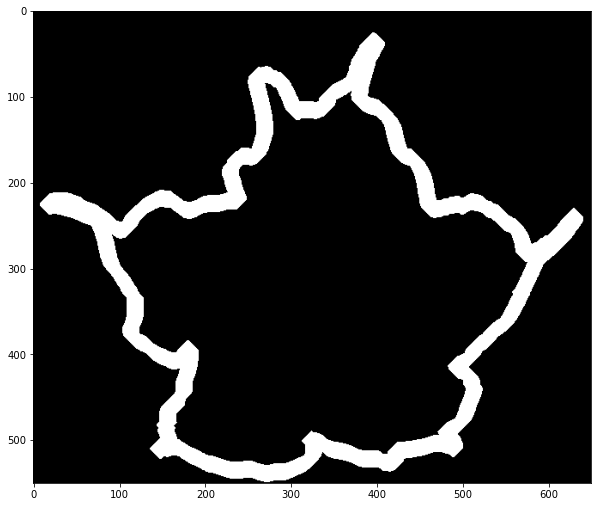

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
import scipy.ndimage.morphology as morph
from imageio import imread


def my_boundary(img):
    """
    Compute boundary of binary image.

    Parameters
    ----------
    img : ndarray of bools
        A binary image.
        
    Returns
    -------
    boundary : ndarray of bools
        The boundary as a binary image.
    """
    boundary = np.zeros(img.shape, bool)
    eroded_img = img
    dilated_img = img
    for _ in range(10):
        eroded_img = morph.binary_erosion(eroded_img)
        dilated_img = morph.binary_dilation(dilated_img)
    boundary = dilated_img ^ eroded_img
    
    return boundary


img = imread("images/engelstrompete.png") > 0
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(my_boundary(img))
plt.show()

### b)  Distance transform

Implement distance transform according to the ideas of (CV-05 slides 34ff).  Discuss the effect of different structuring elements.

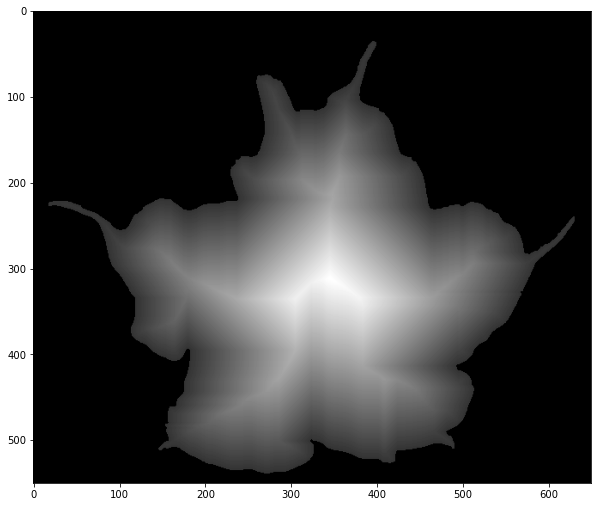

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph, generate_binary_structure
from imageio import imread

def my_distance_transform(img):
    """Distance transform of binary image.

    Args:
    img (ndarray of bools): A binary image.
        
    Returns:
    dt (ndarray of ints): The distance transform of the input image.
    """
    
    dt = np.zeros(img.shape,np.int32)
    i = 0
    
    while True:
        eroded_img = morph.binary_erosion(img, iterations = i+1)
        previous_eroded_img = morph.binary_erosion(img, iterations = i)
        boundary = np.logical_xor(previous_eroded_img, eroded_img)
        boundary = boundary.astype(np.int32)
        boundary_distance = boundary * i
        dt += boundary_distance
        if(np.all(eroded_img == 0)):
            break
        i += 1

    return dt


img = imread("images/engelstrompete.png") > 0
plt.figure(figsize=(10,10))
plt.imshow(my_distance_transform(img) + 50 * img)
plt.show()

The structuring element affects the distance transform because it defines how much we erode in every iteration. The bigger the structure, the more we erode in each iteration and therefore the bigger the stepsize in which we compute the distances.\
Additionally, the shape of the structure and its anchor influence the distance transform. An uneven shape or an anchor that is not in the centre of the structure skew erosion and with it also the distance computation.

Question: I tried several structures in the calls of morph.binary_erosion() but wasn't able to generate the same result. Instead setting the structure argument (e.g. to np.ones((3,3)) ) in the function call leads to quite bad results. Why is that and what is the default structure (documentation states If no structuring element is provided, an element is generated with a square connectivity equal to one.)?

### c) Morphing

Write a function `my_morph` that implements morphing according to (CV-05 slide 41). You may use your function `my_distance_transform` from part b), or the function `distance_transform_edt` from `scipy.ndimage.morphology`.

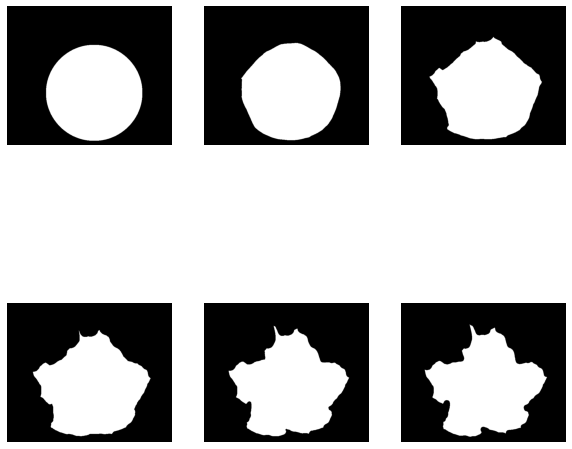

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morph
from imageio import imread


def my_morph(A,B,ratio, threshold=10):
    """Morphing from binary image A to image B.

    Args:
        A (ndarray of bools): A binary image (start).
        B (ndarray of bools): A binary image (target), same shape as A.
        ratio (float from 0.0 to 1.0): The ratio of image A and image B.
            0.0=only image A, 1.0=only image B.
        
    Returns:
        morph (ndarray of bools): A binary intermediate image between A and B.
        
    """
    DA = morph.distance_transform_edt(A)#my_distance_transform(A)
    DB = morph.distance_transform_edt(B)#my_distance_transform(B)
    
    i = ratio
    Di = (i * DB + (1-i) * DA)
    result = Di > threshold
    return result

img1 = imread("images/kreis.png") > 0
img2 = imread("images/engelstrompete.png") > 0

plt.figure(figsize=(10,10))
plt.gray()
for i, ratio in enumerate(np.linspace(0, 1, 6), 1):
    plt.subplot(2, 3, i)
    plt.imshow(my_morph(img1, img2, ratio))
    plt.axis('off')
plt.show()

In [6]:
# If you want to see your morph as an animation, run this cell. 
# Close the output (press the blue "Stop interaction" button) once you are done!

# Due to some matplotlib problem you may have to restart your kernel!
%matplotlib notebook
import matplotlib.animation as animation
fig = plt.figure()

ims = []
for i, ratio in enumerate(np.linspace(0, 1, 24), 1):
    plt.axis('off')
    im = plt.imshow(my_morph(img1, img2, ratio), cmap='gray', animated=True)
    ims.append([im])  
    
ani = animation.ArtistAnimation(fig, ims + list(reversed(ims)), interval=100, blit=True)

fig.show()

<IPython.core.display.Javascript object>

## Assignment 3: Implementation: Skeletonization [5 Points]

### a) Skeletonization with hit-or-miss

Explain in your own words, how the hit-or-miss operator can be used for skeletonization (cf CV-05 slide 49).  

We can use the hit-or-miss operator to identify the location of specific patterns. For skeletonization, we can use this to identify the (left, right, top, bottom, left-top, left-bottom, right-top and right-bottom) borders of an object. The anchors of the borders can definetly not belong to a ridge, because there are still pixels insided of them and the skeleton consists of line with a width of only 1 pixel. So if we iteratively identify borders and remove their anchor pixel from the image (before identifying the next border), we will slowly 'carve' away the borders until only a thin line of pixels remains: the skeleton.

### b) Implementation of skeletonization

Now use this method to implement your own skeletonization function. It is ok to use
`scipy.ndimage.morphology.binary_hit_or_miss` here (but of course *not* `skimage.morphology.skeletonize` or similar functions). Compare your result with (CV-05 slide 50). Note that computing the skeleton using this method may take some time ...

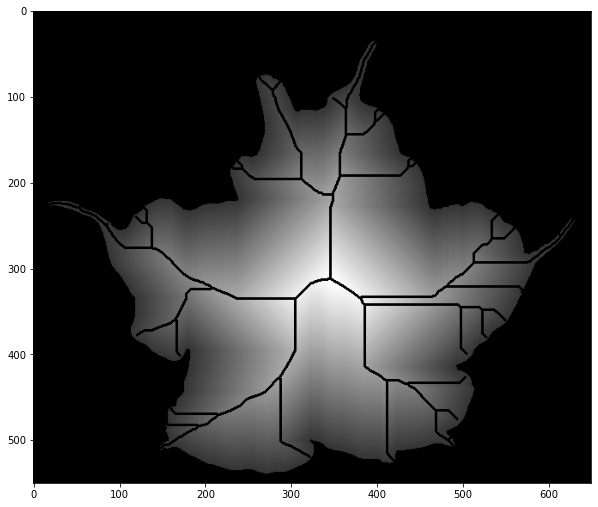

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morph
from imageio import imread


from skimage.morphology import skeletonize


def rotate45(matrix):
    """Rotate a 3X3 matrix by 45 degrees clockwise
    
    Parameters
    ----------
    matrix : ndarray of size 3X3
    
    Returns
    -------
    rotated_matrix : matrix rotated 45 degrees clockwise
    """
    assert matrix.shape == (3,3), "Wrong shape of matrix! Shape should be (3, 3)"
    
    rotated_matrix = np.copy(matrix)
    rotation_matrix = np.array([[0.707,-0.707],
                                [0.707,0.707]])
    for yi in range(-1, 2):
        for xi in range(-1, 2):
            rotated_indices = np.round(rotation_matrix @ np.array([xi, yi]))
            rotated_matrix[int(rotated_indices[1])+1, int(rotated_indices[0])+1] = matrix[yi+1, xi+1]
    return rotated_matrix


def my_skeletonize(img):
    """
    Compute the skeloton of a binary image using hit_or_miss operator.
    
    Parameters
    ----------
    img : ndarray of bools
        Binary image to be skeletonized.
    
    Returns
    -------
    skeleton : ndarray of bools
        The skeleton of the input image.
    """
    # initialize list to hold all 8 rotations
    rotations = [np.array([[1,  1, 1],
                           ['X',1,'X'],
                           [0,  0, 0]])]
    # fill list with the remaining 8 rotations
    for _ in range(7):
        rotations.append(rotate45(rotations[-1]))
    while True:
        skeleton = img
        # iterate through all hit-or-miss rotations to apply them to the image
        for hit_or_miss in rotations:
            hit = np.copy(hit_or_miss).flatten()
            hit[np.where(hit == 'X')[0]] = 0
            
            miss = np.copy(hit_or_miss).flatten()
            miss[np.where(miss == 'X')[0]] = 1
            miss = np.invert(miss.astype(int).astype(bool))
            
            img = img ^ morph.binary_hit_or_miss(img, np.reshape(hit, (3,3)).astype(int), np.reshape(miss, (3,3)))
        if (skeleton == img).all(): break
    return skeleton


img = imread("images/engelstrompete.png") > 0
skel = my_skeletonize(np.copy(img))
result = morph.distance_transform_cdt(img, metric='taxicab') + (50 * img)
result[morph.binary_dilation(skel)] = 0
plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(result)
plt.show()

## Assignment 4: Custom Structuring Element [5 points]

Landsat 7 is a satelite mission for acquisition of satellite imagery of Earth. Unfortunately the Scan Line Corrector failed, resulting in black stripes on the aquired images. More information: https://landsat.usgs.gov/slc-products-background


### a) A first fix

A rather crude fix is to apply a custom structuring element for dilation and erosion (see CV-05, 24ff). Complement the code below (in part (b)) in the following way:
* Rotate the image such that the gaps are horizontal.
* Dilate the rotated image with a vertical structuring element. I.e. take the maximum of an area of size $7 \times1$ and assign it to the center pixel. Repeat for all pixels.
* Erode the dilated image.
* Rotate the result back.

Remark: this exercise applies morphological operator to color images. This extends the idea of generalizing morphological operators to gray value images (CV-05, slide 51).  

### b) Improving the solution
You may get better results by thresholding and applying the morphological operations only to pixels below a threshold, i.e. gap pixels. Compliment your solution from a). 

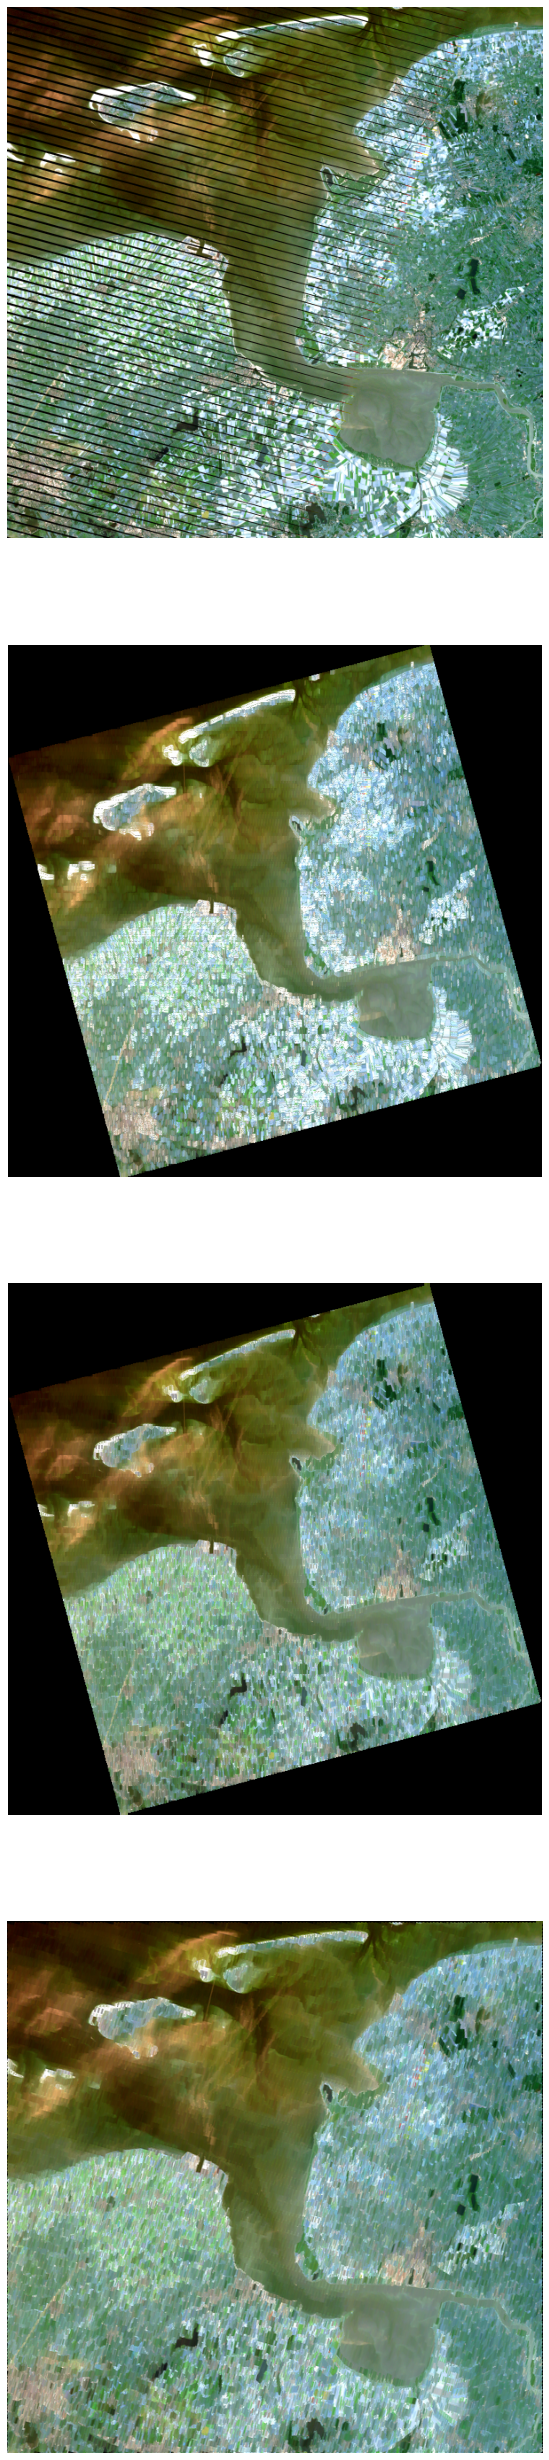

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.morphology as morph
import scipy.ndimage as ndimg
from skimage import color
from skimage.transform import rescale as rescale
from imageio import imread
from scipy.ndimage.interpolation import rotate

# defining the threshold
thresh = 255 * 1.8
struc_elem = np.ones((5,1), dtype=bool)

img = imread("images/landsat_stack2.png")
img2 = img.copy()
img3 = img.copy()

img3 = rotate(img2, angle=-30, reshape=False)

rgb_weights = [0.2989, 0.5870, 0.1140]
img_grey = np.dot(img, rgb_weights)

# extract line angle for image rotation
angle_mins = []
for angle in range(180):
    rotated_img = rotate(img_grey, angle=angle, reshape=False)
    min_val = 10000
    for y in range(100,300):#rotated_img.shape[0]):
        line_sum = rotated_img[y:y+1, 100:130].sum()
        if line_sum < min_val:
            min_val = line_sum
    angle_mins.append(min_val)
line_angle = angle_mins.index(min(angle_mins))

# rotate image
img2 = rotate(img2, angle=line_angle, reshape=True)
img_dilated = np.copy(img2)

# Dilate img2 with a vertiacal 7x1 structuring element
for yi in range(img2.shape[0]):
    for xi in range(img2.shape[0]):
        if img2[yi, xi].sum() < thresh:
            shift_up = 3 if yi>3 else 3-(3-yi)
            shift_down = 3 if yi<img2.shape[0]-3 else img2.shape[0]-yi
            cutout = img2[yi-shift_up:yi+shift_down, xi]
            cutout_maxima = cutout.max(axis=0)
            img_dilated[yi, xi] = cutout_maxima
        else:
            img_dilated[yi, xi] = img2[yi, xi]

# Erode img_dilated with a vertical 7x1 structuring element
img_eroded = img_dilated.copy()
for yi in range(img_dilated.shape[0]):
    for xi in range(img_dilated.shape[0]):
        shift_up = 3 if yi>3 else 3-(3-yi)
        shift_down = 3 if yi<img_dilated.shape[0]-3 else img_dilated.shape[0]-yi
        cutout = img_dilated[yi-shift_up:yi+shift_down, xi]
        cutout_minima = cutout.min(axis=0)
        img_eroded[yi, xi] = cutout_minima
        
# rotate back
img_final = rotate(img_eroded, angle=-line_angle)
img_final = img_final[int((img_final.shape[0]-img.shape[0])/2):img_final.shape[0]-int((img_final.shape[0]-img.shape[0])/2),
                      int((img_final.shape[1]-img.shape[1])/2):img_final.shape[1]-int((img_final.shape[1]-img.shape[1])/2)]

plt.figure(figsize=(15,45))
plt.subplot(4,1,1); plt.imshow(img); plt.axis('off')
plt.subplot(4,1,2); plt.imshow(img_dilated); plt.axis('off')
plt.subplot(4,1,3); plt.imshow(img_eroded); plt.axis('off')
plt.subplot(4,1,4); plt.imshow(img_final); plt.axis('off')
#plt.imshow(img3)
plt.show()

### c) Bonus
Can you think of (and implement) other ways to add the missing data? 


YOUR ANSWER HERE